In [1]:
import numpy as np
import os
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Bidirectional
from keras.regularizers import L1L2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tf2crf import CRF
from transformers import TFBertForPreTraining, TFBertModel, BertTokenizerFast

import keras.backend as K
import pandas as pd
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

c:\Users\Egor\Anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# model = TFBertForPreTraining.from_pretrained(r'rubert_cased_L-12_H-768_A-12_pt_v1', from_pt=True)
# model.save('RuBERT_pretrained')
# model.save_pretrained('RuBERT_pretrained')

In [3]:
total_size = 100_000
MAX_LEN = 100

In [4]:
X_all = []
y_all = []

# # Если меняем total_size, то переписать файлы

# with open('data/nerus/bert_data/nerus_x.pickle', 'rb') as f:
#     X_all.extend(pickle.load(f)[:total_size//2])

# with open('data/nerus/bert_data/nerus_y.pickle', 'rb') as f:
#     y_all.extend(pickle.load(f)[:total_size//2])

# with open('data/wikiner/bert_data/wikiner_x.pickle', 'rb') as f:
#     X_all.extend(pickle.load(f)[:total_size//2])

# with open('data/wikiner/bert_data/wikiner_y.pickle', 'rb') as f:
#     y_all.extend(pickle.load(f)[:total_size//2])

# with open('data/all/x_all.pickle', 'wb') as f:
#     pickle.dump(X_all, f)

# with open('data/all/y_all.pickle', 'wb') as f:
#     pickle.dump(y_all, f)


In [5]:
with open('data/all/x_all.pickle', 'rb') as f:
    X_all = pickle.load(f)

with open('data/all/y_all.pickle', 'rb') as f:
    y_all = pickle.load(f)

In [6]:
y_all = [y+1 for y in y_all]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=77)

In [8]:
bert_tokenizer = BertTokenizerFast('RuBERT_tokenizer/vocab.txt')
def tokenize(data, max_len=MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = bert_tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = max_len,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True, return_tensors = 'np')
                        
        
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids), np.vstack(attention_mask)

In [9]:
input_ids, attention_mask = tokenize(X_train, max_len = MAX_LEN)
val_input_ids, val_attention_mask = tokenize(X_test, max_len = MAX_LEN)

  0%|          | 0/80000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [10]:
train_tag = tf.keras.utils.pad_sequences(y_train, maxlen=MAX_LEN, padding='post', value=0, dtype=np.uint8)
test_tag = tf.keras.utils.pad_sequences(y_test, maxlen=MAX_LEN, padding='post', value=0, dtype=np.uint8)

In [11]:
def macro_f1(y_true, y_pred):  # macro F-score
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(y_true * y_pred))
        Positives = K.sum(K.round(y_true))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    y_true = tf.one_hot(tf.cast(y_true, 'uint8'), depth=8)

    f_classes = []
    for i in range(8):   # Считаем f_score для каждого класса и усредняем
        y_t = y_true[:, :, i]
        y_p = y_pred[:, :, i]
        precision, recall = precision_m(y_t, y_p), recall_m(y_t, y_p)
        f = 2*((precision*recall)/(precision+recall+K.epsilon()))
        f_classes.append(f)
        
    return tf.math.reduce_mean(f_classes)

In [12]:
class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy()
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true != 0), dtype=tf.float32)
        
        return loss * mask

custom_loss = CustomNonPaddingTokenLoss()

In [13]:
checkpoint = ModelCheckpoint('./checkpoints/elmo_bilstm_crf/best', monitor='val_macro_f1', mode='max',
                                                save_best_only=True, save_weights_only=True)

stop_early = EarlyStopping(monitor='val_macro_f1', mode='max', patience=8)

In [14]:
# macro_f1 = MacroF1(n_tags = 8)

def create_model(bert_model, max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,), dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,), dtype = 'int32')
    bert_output = bert_model(input_ids, attention_mask = attention_masks, return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])

    # dense_1 = TimeDistributed(Dense(512, activation="relu", kernel_regularizer=L1L2(l1=0.00, l2=0.00)))(embedding)
    # dense_1 = tf.keras.layers.Dropout(0.5)(dense_1)
    output = tf.keras.layers.Dense(8, activation = 'softmax')(embedding)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    loss=custom_loss, metrics=[macro_f1])
    return model


In [15]:
checkpoint = ModelCheckpoint('./checkpoints/bert_fine_tuned/best', monitor='val_macro_f1', mode='max',
                                                save_best_only=True, save_weights_only=True)

stop_early = EarlyStopping(monitor='val_macro_f1', mode='max', patience=5)

In [16]:
bert_model = TFBertModel.from_pretrained('RuBERT_pretrained')
ner_model = create_model(bert_model)

Some layers from the model checkpoint at RuBERT_pretrained were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at RuBERT_pretrained.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [17]:
model_history = ner_model.fit([input_ids,attention_mask], np.array(train_tag), 
                validation_data = ([val_input_ids,val_attention_mask], np.array(test_tag)),
                epochs=100, batch_size=80,
                callbacks = [checkpoint, stop_early])

Epoch 1/100
1000/1000 [==============================] - 339s 332ms/step - loss: 0.0199 - macro_f1: 0.3344 - val_loss: 0.0081 - val_macro_f1: 0.5767
Epoch 2/100
1000/1000 [==============================] - 327s 326ms/step - loss: 0.0076 - macro_f1: 0.6242 - val_loss: 0.0050 - val_macro_f1: 0.7662
Epoch 3/100
1000/1000 [==============================] - 327s 327ms/step - loss: 0.0053 - macro_f1: 0.7476 - val_loss: 0.0039 - val_macro_f1: 0.8209
Epoch 4/100
1000/1000 [==============================] - 324s 323ms/step - loss: 0.0042 - macro_f1: 0.8049 - val_loss: 0.0035 - val_macro_f1: 0.8509
Epoch 5/100
1000/1000 [==============================] - 324s 323ms/step - loss: 0.0035 - macro_f1: 0.8409 - val_loss: 0.0032 - val_macro_f1: 0.8648
Epoch 6/100
1000/1000 [==============================] - 324s 324ms/step - loss: 0.0030 - macro_f1: 0.8654 - val_loss: 0.0033 - val_macro_f1: 0.8664
Epoch 7/100
1000/1000 [==============================] - 324s 323ms/step - loss: 0.0026 - macro_f1: 0.8843

In [36]:
ner_model.load_weights('./checkpoints/bert_fine_tuned/best')
# ner_model.save_weights('./models/bert_fine_tuned/bert_fine_tuned')

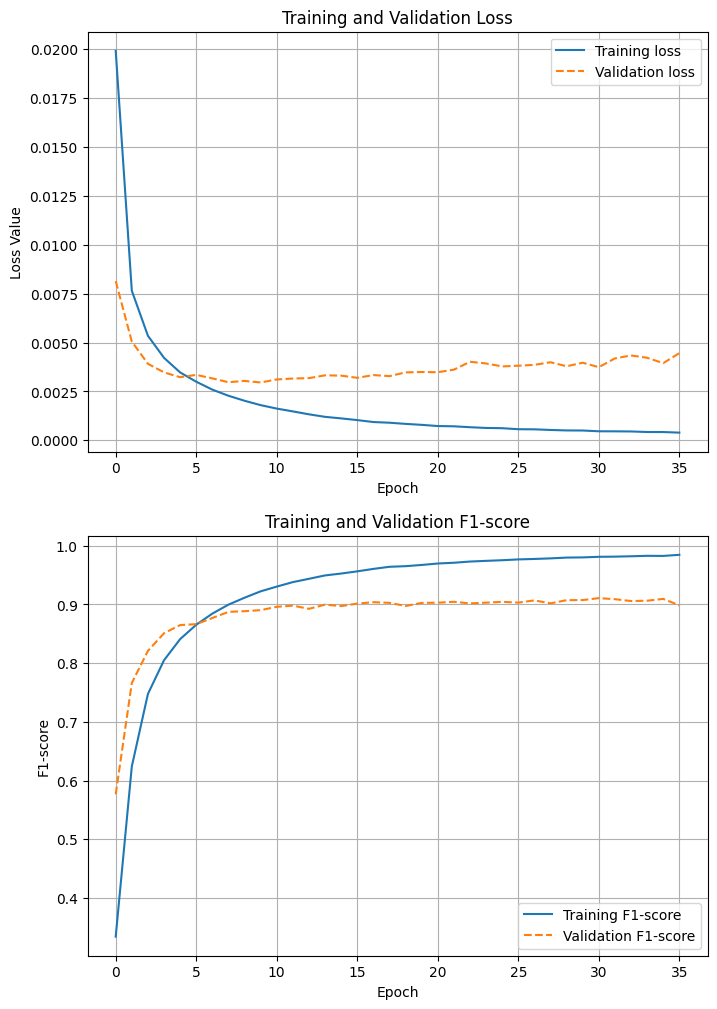

In [37]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

f1 = model_history.history['macro_f1']
val_f1 = model_history.history['val_macro_f1']

plt.figure(figsize=(8,12))
plt.subplot(211)
plt.plot(model_history.epoch, loss, '-', label='Training loss')
plt.plot(model_history.epoch, val_loss, '--', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.grid()
plt.legend()

plt.subplot(212)
plt.plot(model_history.epoch, f1, '-', label='Training F1-score')
plt.plot(model_history.epoch, val_f1, '--', label='Validation F1-score')
plt.title('Training and Validation F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.grid()
plt.legend()
plt.show()

In [20]:
ner_model.load_weights('./models/bert_fine_tuned/bert_fine_tuned')

In [21]:
def multiclass_accuracy(y_pred, y_true):
    return np.mean(np.equal(y_true, np.argmax(y_pred, axis=-1)))

y_test_pred = ner_model.predict([val_input_ids, val_attention_mask])

test_accuracy = multiclass_accuracy(y_test_pred, test_tag)

print(test_accuracy)

625/625 [==============================] - 23s 35ms/step
0.996578


In [18]:
# from sklearn.metrics import classification_report

In [22]:
tags_inv = {
    0: '[PAD]',
    1: 'O',
    2: 'B-PER',
    3: 'I-PER',
    4: 'B-ORG',
    5: 'I-ORG',
    6: 'B-LOC',
    7: 'I-LOC'
}

tag_names = list(tags_inv.values())

In [23]:
def check_on_sentence(sentences):
    tokens = tokenize(sentences)
    tags = np.argmax(ner_model.predict(tokens), axis=-1)
    out = []
    ls = [np.sum(t[1]) for t in tokens]
    for i in range(len(tokens)):
        out.append([sentences[i], tags[i][:ls[i]]])       

    return out

In [24]:
from nltk.tokenize import word_tokenize, sent_tokenize, WordPunctTokenizer
from tabulate import tabulate

In [25]:
text = '''\
Пожалуйста, предоставьте Михаилу Ивановичу Резниченко офис по адресу г. Москва, улица Орджоникидзе, дом 11.
Генеральный директор оператора "Северного потока - 2" - компании Nord Stream 2 AG - Маттиас Варниг в конце марта покинет пост главы компании, говорится в сообщении оператора.
'''

In [32]:
text = '''\
"Маттиас Варниг завершит свой срок пребывания на посту генерального директора Nord Stream 2 AG и уйдет в отставку в конце марта 2023 года", - говорится в сообщении. Дальнейшая эксплуатация Nord Stream 2 AG будет осуществляться управляющим комитетом под руководством администратора Transliq AG.
"Nord Stream 2 признает и по-настоящему ценит выдающееся руководство и неоценимый вклад Маттиаса Варнига на протяжении долгого и сложного пути создания крупной трансграничной инфраструктуры энергоснабжения и желает ему успехов во всех его будущих начинаниях", - говорится в сообщении.
В конце декабря 2022 года сообщалось, что процедура банкротства Nord Stream 2 AG продлена еще на шесть месяцев, до июля 2023 года. Как следует из заявления, суд в швейцарском Цуге по просьбе компании выдал Nord Stream 2 AG постоянный мораторий на выплату кредитов вместо действовавшего до этого временного моратория.
Газета Stuttgarter Zeitung со ссылкой на гендиректора компании Маттиаса Варнига в марте 2022 года сообщала, что Nord Stream 2 AG намерена подать заявление о банкротстве. В самой компании тогда не подтверждали сообщения о начале процедуры банкротства и заявляли, что только проинформировали власти Швейцарии о вынужденном расторжении контрактов с персоналом.
'''

In [26]:
def print_tags(data):
    tokens, tags = data
    t_inv = [tags_inv[t] for t in tags]
    print(tabulate(zip(tokens, t_inv)))

In [27]:
def tokenize_text(text):
    s_t = sent_tokenize(text)
    return [WordPunctTokenizer().tokenize(s) for s in s_t]

def text_to_predict(text):
    tok = tokenize_text(text)
    for sent in check_on_sentence(tok):
        print_tags(sent)

In [28]:
text_to_predict(text)

  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
------------  -----
Пожалуйста    O
,             O
предоставьте  O
Михаилу       B-PER
Ивановичу     I-PER
Резниченко    I-PER
офис          O
по            O
адресу        O
г             O
.             B-LOC
Москва        O
,             O
улица         B-LOC
Орджоникидзе  O
,             O
дом           O
11            O
.             [PAD]
------------  -----
-----------  -----
Генеральный  O
директор     O
оператора    O
"            O
Северного    O
потока       O
-            O
2            O
"            O
-            B-ORG
компании     I-ORG
Nord         I-ORG
Stream       I-ORG
2            I-PER
AG           O
-            O
Маттиас      O
Варниг       O
в            O
конце        O
марта        O
покинет      O
пост         O
главы        O
компании     O
,            O
говорится    [PAD]
в            [PAD]
сообщении    [PAD]
оператора    [PAD]
.            [PAD]
-----------  -----


In [29]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [30]:
y_pred = ner_model.predict([val_input_ids, val_attention_mask], verbose=1)
y_pred = np.argmax(y_pred, axis=-1)

625/625 [==============================] - 23s 36ms/step


In [31]:
# ner_model.evaluate([val_input_ids, val_attention_mask], test_tag)

625/625 [==============================] - 38s 57ms/step - loss: 0.0038 - macro_f1: 0.9027


[0.0037526790983974934, 0.902748167514801]

In [34]:
print(classification_report(test_tag.flatten(), y_pred.flatten(), labels=[1,2,3,4,5,6,7], digits=4,
                            target_names = tag_names[1:]))

              precision    recall  f1-score   support

           O     0.9915    0.9918    0.9916    324989
       B-PER     0.9323    0.9412    0.9367      7315
       I-PER     0.9484    0.9536    0.9510      5798
       B-ORG     0.8670    0.8614    0.8642      5658
       I-ORG     0.8488    0.8191    0.8337      4449
       B-LOC     0.9153    0.9060    0.9106     11234
       I-LOC     0.8080    0.7981    0.8031      2769

   micro avg     0.9823    0.9818    0.9821    362212
   macro avg     0.9016    0.8959    0.8987    362212
weighted avg     0.9822    0.9818    0.9820    362212



<Axes: >

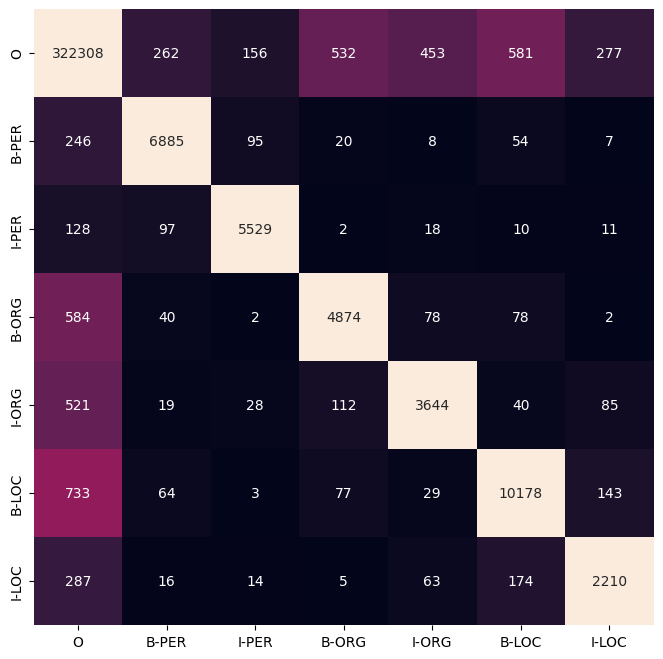

In [35]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(test_tag.flatten(), y_pred.flatten(), labels=[1,2,3,4,5,6,7]),
            annot=True, fmt='d', xticklabels=tag_names[1:], yticklabels=tag_names[1:], vmax=2000, cbar=False)